In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Define passenger data from heatmap
## This data is from the heatmap of the number of passengers per hour of the week
data = {
    'Hour': range(24),
    'Monday': [2, 2, 2, 3, 3, 6, 13, 29, 61, 37, 32, 31, 39, 28, 26, 25, 29, 33, 34, 25, 18, 11, 6, 4],
    'Tuesday': [2, 2, 2, 3, 2, 5, 13, 31, 59, 38, 29, 28, 33, 26, 25, 24, 30, 35, 38, 27, 22, 12, 9, 3],
    'Wednesday': [3, 1, 1, 1, 1, 3, 10, 30, 60, 43, 36, 36, 48, 36, 34, 32, 36, 41, 40, 27, 21, 14, 9, 6],
    'Thursday': [2, 2, 2, 3, 3, 6, 14, 36, 63, 47, 40, 41, 49, 42, 42, 36, 42, 48, 40, 26, 22, 15, 9, 5],
    'Friday': [4, 2, 3, 4, 3, 6, 13, 32, 61, 49, 43, 39, 54, 47, 45, 41, 45, 44, 44, 28, 23, 19, 16, 7],
    'Saturday': [5, 3, 3, 4, 3, 7, 10, 18, 23, 29, 43, 37, 41, 38, 36, 35, 36, 39, 33, 23, 19, 17, 14, 6],
    'Sunday': [3, 1, 1, 0, 1, 2, 4, 11, 21, 35, 43, 57, 55, 58, 62, 56, 59, 55, 42, 31, 21, 23, 13, 5]
}
df = pd.DataFrame(data)


In [3]:
# Step 2: Calculate total passengers per hour (25 stops)
for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    df[f'{day}_total'] = df[day] * 25

In [4]:
# Step 3: Average demand for weekdays and weekends
df['Weekday_avg'] = df[['Monday_total', 'Tuesday_total', 'Wednesday_total', 'Thursday_total', 'Friday_total']].mean(axis=1)
df['Weekend_avg'] = df[['Saturday_total', 'Sunday_total']].mean(axis=1)

In [5]:
# Step 4: Define route parameters
route_time = 40  # Minutes per loop (from TSP)
bus_capacity = 40  # Passengers per bus
service_start = datetime(2025, 4, 1, 5, 0)  # 5 AM
service_end = datetime(2025, 4, 1, 23, 0)  # 11 PM

In [6]:
# Step 5: Set frequency based on demand
def get_frequency(total_passengers):
    if total_passengers > 1000:  # >40/stop
        return 15  # 10-15 min
    elif total_passengers > 500:  # 20-40/stop
        return 20  # 20-30 min
    elif total_passengers > 250:  # 10-20/stop
        return 30  # 30-45 min
    else:  # <10/stop
        return 60  # 45-60 min

In [8]:
# Step 6: Generate timetable for weekdays and weekends
def generate_timetable(demand_series, label):
    frequencies = {}
    for hour in range(24):
        total_passengers = demand_series.iloc[hour]
        frequencies[hour] = get_frequency(total_passengers)

    timetable = []
    current_time = service_start
    buses_needed = 0
    while current_time < service_end:
        hour = current_time.hour
        freq = frequencies.get(hour, 60)
        timetable.append(current_time)
        current_time += timedelta(minutes=freq)
        buses_for_freq = -(-route_time // freq)  # Ceiling division
        buses_needed = max(buses_needed, buses_for_freq)

    schedule_df = pd.DataFrame({'departure_time': timetable})
    schedule_df['departure_time'] = schedule_df['departure_time'].dt.strftime('%H:%M')
    schedule_df.to_csv(f"../output/bus_schedule_{label}.csv", index=False)
    return schedule_df, buses_needed

# Generate schedules
weekday_schedule, weekday_buses = generate_timetable(df['Weekday_avg'], "weekday")
weekend_schedule, weekend_buses = generate_timetable(df['Weekend_avg'], "weekend")


In [9]:
# Step 7: Print results
print(f"Weekday Schedule (first 10 departures):")
print(weekday_schedule.head(10))
print(f"Weekday Buses Needed: {weekday_buses}\n")
print(f"Weekend Schedule (first 10 departures):")
print(weekend_schedule.head(10))
print(f"Weekend Buses Needed: {weekend_buses}")


Weekday Schedule (first 10 departures):
  departure_time
0          05:00
1          06:00
2          06:30
3          07:00
4          07:20
5          07:40
6          08:00
7          08:15
8          08:30
9          08:45
Weekday Buses Needed: 3

Weekend Schedule (first 10 departures):
  departure_time
0          05:00
1          06:00
2          07:00
3          07:30
4          08:00
5          08:20
6          08:40
7          09:00
8          09:20
9          09:40
Weekend Buses Needed: 3


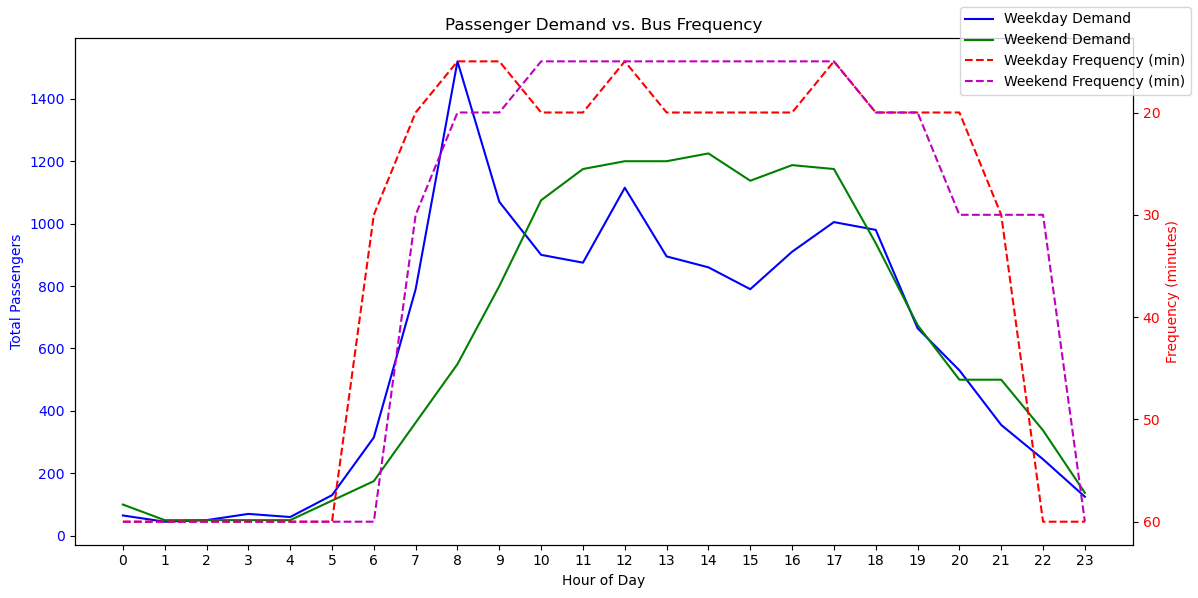

In [10]:
# Step 8: Visualize demand vs. frequency
fig, ax1 = plt.subplots(figsize=(12, 6))
hours = range(24)
ax1.plot(hours, df['Weekday_avg'], 'b-', label='Weekday Demand')
ax1.plot(hours, df['Weekend_avg'], 'g-', label='Weekend Demand')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Passengers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
weekday_freq = [get_frequency(d) for d in df['Weekday_avg']]
weekend_freq = [get_frequency(d) for d in df['Weekend_avg']]
ax2.plot(hours, weekday_freq, 'r--', label='Weekday Frequency (min)')
ax2.plot(hours, weekend_freq, 'm--', label='Weekend Frequency (min)')
ax2.set_ylabel('Frequency (minutes)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()

plt.title('Passenger Demand vs. Bus Frequency')
fig.legend(loc='upper right')
plt.xticks(hours)
plt.tight_layout()
plt.show()